In [21]:
from transformers import T5ForConditionalGeneration, T5Tokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, SequentialSampler, RandomSampler
from transformers import AdamW, get_linear_schedule_with_warmup

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, matthews_corrcoef, auc, roc_curve
import orjson as json
import re
from tqdm.notebook import tqdm
from torchmetrics.functional import accuracy
import os

In [22]:
# Hyperparams
batch_size = 32
epochs = 3
lr = 1e-4

# Load and prepare data

In [3]:
df = pd.read_csv('data/sentiment-analysis-on-movie-reviews/train.tsv', sep='\t')

In [4]:
with open('data/labels.json', 'r') as json_file:
    labels = json.loads(json_file.read())

In [5]:
labels_index = dict([(labels[index], index) for index in labels])

In [6]:
tokenizer = T5Tokenizer.from_pretrained('t5-small')

In [7]:
inputs = df['Phrase'].apply(lambda x: re.sub('[^A-Za-z0-9]+', ' ', x).strip()).tolist()
targets = df['Sentiment'].apply(lambda x: labels[str(x)]).tolist()

In [8]:
# Split data 
train_inputs, test_inputs, train_targets, test_targets = train_test_split(inputs, targets, test_size=0.2, stratify=targets, random_state=2021)

In [9]:
class SentimentDataset(Dataset):
    def __init__(self, inputs, target, tokenizer, max_length=100, set_type='train'):
        self.inputs = inputs
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.set_type = set_type
        
    def __len__(self):
        return len(self.inputs)
    
    def __getitem__(self, index):
        target = self.targets[index]
        input_sent = self.inputs[index]
        
        src_tokenized = self.tokenizer.encode_plus(
            input_sent, 
            max_length=self.max_length,
            padding='max_length',
            truncation=True,
            return_token_type_ids=False,
            return_tensors='pt'
        )
        
        input_ids = src_tokenized['input_ids'].squeeze()
        src_mask = src_tokenized['attention_mask'].squeeze()
        
        if self.set_type == 'train':
            target_tokenized = self.tokenizer.encode_plus(
                target,
                max_length=self.max_length,
                padding='max_length',
                truncation=True,
                return_token_type_ids=False,
                return_tensors='pt'
            )
            
            target_ids = target_tokenized['input_ids'].squeeze()
            target_mask = target_tokenized['attention_mask'].squeeze()
            
            return {
                'input_ids': input_ids.long(),
                'src_mask': src_mask.long(),
                'target_ids': target_ids.long(),
                'target_mask': target_mask.long()
            }
        
        else:
            return {
                'input_ids': input_ids.long(),
                'src_mask': src_mask.long(),
                'label': target
            }

In [10]:
# Set dataset and loader
train_dataset = SentimentDataset(train_inputs, train_targets, tokenizer, set_type='train')
test_dataset = SentimentDataset(test_inputs, test_targets, tokenizer, set_type='test')

In [11]:
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=batch_size, num_workers=6)

test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=batch_size, num_workers=6)

# Prepare and train t5 model

In [12]:
model = T5ForConditionalGeneration.from_pretrained('t5-small')
model.to('cuda')

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseReluDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Dro

In [13]:
optimzer = AdamW(model.parameters(), lr=lr, eps=1e-8)
scheduler = get_linear_schedule_with_warmup(
    optimzer, num_warmup_steps=400, num_training_steps=len(train_dataloader) * epochs
)

# Custom training loop

In [17]:
for i in tqdm(range(epochs)):
    model.train()
    
    total_loss = 0
    for step, batch in tqdm(enumerate(train_dataloader), total=len(train_dataloader)):
        b_src_input_ids = batch['input_ids'].to('cuda')
        b_src_attn_mask = batch['src_mask'].to('cuda')
        
        lm_labels = batch['target_ids'].to('cuda')
        lm_labels[labels == tokenizer.pad_token_id] = -100 # Set to ignore token
        
        # Forward pass
        optimzer.zero_grad()
        logits = model(
            input_ids=b_src_input_ids,
            attention_mask=b_src_attn_mask,
            labels=lm_labels
        )
        
        loss = logits[0]
        
        # Backpropagation
        loss.backward()
        total_loss += loss.item()
        scheduler.step()
        optimzer.step()
        
    avg_train_loss = total_loss / len(train_dataloader)
    print('Training loss:', avg_train_loss)
    
    # Model validation
    model.eval()

    y_true = []
    y_pred = []

    for step, batch in enumerate(tqdm(test_dataloader)):
        b_src_input_ids = batch['input_ids'].to('cuda')
        b_stc_attn_mask = batch['src_mask'].to('cuda')

        with torch.no_grad():
            outputs = model.generate(b_src_input_ids)

        decoded_output = tokenizer.batch_decode(outputs, clean_up_tokenization_spaces=True, skip_special_tokens=True)
        y_true.append([int(labels_index[b]) for b in batch['label']])
        y_pred.append([int(labels_index[output]) if output in labels_index else 2 for output in decoded_output])

    y_true = torch.tensor(np.concatenate(y_true))
    y_pred = torch.tensor(np.concatenate(y_pred))
    print('Acc: {}'.format(accuracy(y_pred, y_true)))


Training loss: 0.018922324786425738



Acc: 0.49471357464790344



Training loss: 0.014927716509724033



Acc: 0.5177496075630188



Training loss: 0.014714709616030854



Acc: 0.5177496075630188



# Model evaluation

In [18]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1156
           1       0.15      0.01      0.02      5002
           2       0.55      0.91      0.69     17152
           3       0.21      0.08      0.12      6304
           4       0.00      0.00      0.00      1598

    accuracy                           0.52     31212
   macro avg       0.18      0.20      0.16     31212
weighted avg       0.37      0.52      0.40     31212



/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/superceed1/anaconda3/envs/py38torch17/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

<AxesSubplot:>

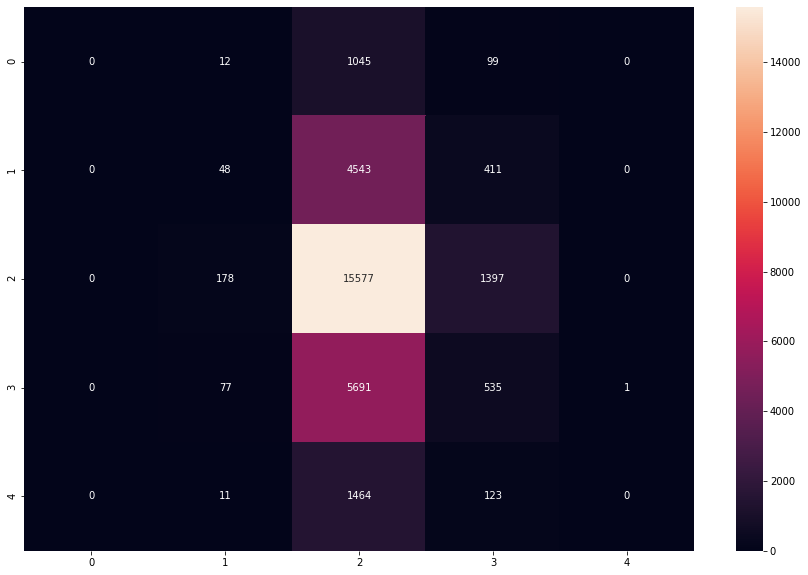

In [19]:
plt.figure(figsize=(15, 10))
sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d')

In [20]:
print(matthews_corrcoef(y_true, y_pred))

0.002638660481173625


Label: 0 : AUC Score: 0.5017905302259311
Label: 1 : AUC Score: 0.5004357165947051
Label: 2 : AUC Score: 0.49922639024715504
Label: 3 : AUC Score: 0.5007331039137732
Label: 4 : AUC Score: 0.49898811728005044


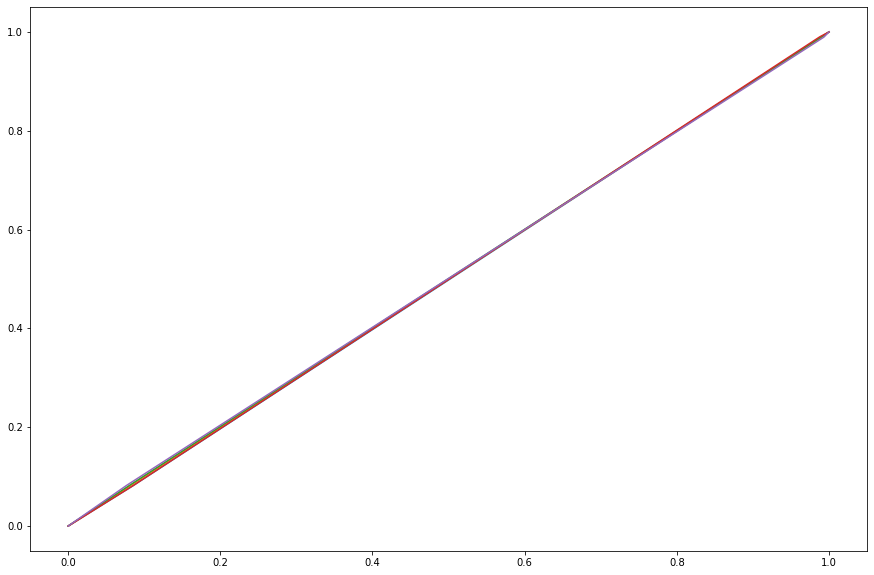

In [30]:
plt.figure(figsize=(15, 10))
for i in range(5):
    fpr, tpr, threshold = roc_curve(y_true, y_pred, pos_label=i)
    plt.plot(tpr, fpr)
    print('Label: {} : AUC Score: {}'.format(i, auc(fpr, tpr)))

# Save model for later use

In [23]:
if not os.path.exists('model'):
    os.makedirs('model')
    
model.save_pretrained('model/')